### Test case LVV-T1753 - Verify calculation of RMS difference of separations relative to r-band

Verify that the DM system has provided the code to calculate the separations measured relative to the r-band, and assess whether it meets the requirement that it shall be less than **AB1 = 10 milliarcseconds**.

#### AND

### Test case LVV-T1750 - Verify calculation of separations relative to r-band exceeding color difference outlier limit

Verify that the DM system has provided the code to calculate the separations measured relative to the r-band that exceed the color difference outlier limit **AB2 = 20 milliarcseconds**, and assess whether it meets the requirement that it shall be less than **ABF1 = 10 percent**.

#### Discussion:
These tests can be verified using data products produced during regular reprocessing campaigns executed by the Data Management pipelines team. In particular, we will use the regularly-reprocessed HSC RC2 data as reprocessed with weekly pipelines version w_2024_34, in Butler collection “HSC/runs/RC2/w_2024_34/DM-45857".

The `AB1` and `ABF1` metrics and related plots are created by tasks in the `analysis_tools` package (specifically, the [TargetRefCatDeltaColorMetrics](https://github.com/lsst/analysis_tools/blob/6903dfedeb0232d1cc74fffcbea35eeab1598c08/python/lsst/analysis/tools/atools/refCatMatchPlots.py#L649-L764) task). Thus verification of this requirement can be accomplished by simply retrieving the datasets produced by those tasks and confirming that they meet the required accuracy.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table

from lsst.daf.butler import Butler
from IPython.display import Image

In [2]:
# Initialize the butler repo pointing to the DM-45857 (w_2024_34) collection
repo = '/repo/main'
collection = 'u/jcarlin/atools_visitQualityCore_AB1'

butler = Butler(repo, collections=collection)

Retrieve results for a set of 5 visits in each of the g, r, i, and z bands:

In [3]:
visit_list = [26044,26046,26048,26050,26058,23884,23886,23888,23890,23898,1302,1306,1308,1310,1314,23250,23256,23258,27090,27094]
bands_list = ['g', 'g', 'g', 'g', 'g', 'r', 'r', 'r', 'r', 'r', 'i', 'i', 'i', 'i', 'i', 'z', 'z', 'z', 'z', 'z']

Loop over the visits and extract the metrics for each one:

In [4]:
ab1_ra_list = []
ab1_dec_list = []
ab1_tot_list = []
abf1_ra_list = []
abf1_dec_list = []
abf1_tot_list = []
dataids_list = []

for vis in visit_list:
    did0 = {'instrument':'HSC', 'skymap':'hsc_rings_v1', 'visit':vis}
    dataids_list.append(did0)
    metric_extract0 = butler.get('sourceObjectTable_metrics', collections=collection, dataId=did0)
    ab1_ra_list.append(metric_extract0['astromColorDiffMetrics'][0].quantity.value)
    ab1_dec_list.append(metric_extract0['astromColorDiffMetrics'][2].quantity.value)
    ab1_tot_list.append(metric_extract0['astromColorDiffMetrics'][4].quantity.value)
    abf1_ra_list.append(metric_extract0['astromColorDiffMetrics'][1].quantity.value)
    abf1_dec_list.append(metric_extract0['astromColorDiffMetrics'][3].quantity.value)
    abf1_tot_list.append(metric_extract0['astromColorDiffMetrics'][5].quantity.value)
    

Place the results into a table:

In [5]:
tab = Table([visit_list, bands_list, ab1_ra_list, ab1_dec_list, ab1_tot_list, abf1_ra_list, abf1_dec_list, abf1_tot_list],
            names=['visit', 'band', 'ab1_ra', 'ab1_dec', 'ab1_tot', 'abf1_ra', 'abf1_dec', 'abf1_tot'],
            units=['', '', 'mas', 'mas', 'mas', '%', '%', '%'])

In [6]:
tab

visit,band,ab1_ra,ab1_dec,ab1_tot,abf1_ra,abf1_dec,abf1_tot
,,mas,mas,mas,%,%,%
int64,str1,float64,float64,float64,float64,float64,float64
26044,g,3.650680062795275,4.468768783736823,5.791720739321608,0.0,0.0,0.0
26046,g,3.874667532283035,4.3043317473923075,5.806685942591208,0.1037344398340249,0.1037344398340249,0.3112033195020747
26048,g,3.8739086880001152,4.306863632466594,5.877020866531886,0.0,0.0,0.0
26050,g,3.6644363819592027,3.9277900932699463,5.425082016769175,0.0,0.0,0.0
26058,g,3.310385930618475,4.9969414923627085,5.996188715224293,0.0,0.3058103975535168,0.3058103975535168
23884,r,2.2559941503047463,2.630665847355618,3.458239026023966,0.0,0.0,0.0
23886,r,7.207078930705799,3.9436877745769348,8.248137855284496,0.09250693802035154,0.09250693802035154,0.09250693802035154
23888,r,3.0737077667113493,2.9005950728762193,4.2141520451041385,0.0,0.0,0.0


Calculate mean values for each metric in each band:

In [7]:
bands = ['g', 'i', 'z']
from collections import defaultdict

avg_values = defaultdict(list)

metrics_list = ['ab1_ra', 'ab1_dec', 'ab1_tot', 'abf1_ra', 'abf1_dec', 'abf1_tot']
units_list = ['mas', 'mas', 'mas', '%', '%', '%']

for band in bands:
    inband = (tab['band']==band)
    for metric in metrics_list:
        avg_values[band].append({metric:np.mean(tab[inband][metric])})

In [8]:
for band in bands:
    print(band)
    for i in range(len(metrics_list)):
        print(metrics_list[i], '=', "%.2F" % avg_values[band][i][metrics_list[i]], units_list[i])
    print('')

g
ab1_ra = 3.67 mas
ab1_dec = 4.40 mas
ab1_tot = 5.78 mas
abf1_ra = 0.02 %
abf1_dec = 0.08 %
abf1_tot = 0.12 %

i
ab1_ra = 8.62 mas
ab1_dec = 10.73 mas
ab1_tot = 11.62 mas
abf1_ra = 2.72 %
abf1_dec = 3.67 %
abf1_tot = 5.78 %

z
ab1_ra = 12.32 mas
ab1_dec = 11.27 mas
ab1_tot = 17.60 mas
abf1_ra = 0.38 %
abf1_dec = 0.67 %
abf1_tot = 1.47 %



Looking at the metrics from _total_ offsets, we see that AB1 is less than the required 10 mas in g-band, but does not meet this threshold in i- or z-band. ABF1 is well below the required 10% value. Note, however, that these tests are meant solely to confirm that the tools exist to _measure_ the metrics; clearly more work must be done in the future for these metrics to meet the thresholds.

### Plots associated with the metrics

Retrieve the plots that are created alongside the metrics by `analysis_tools`, and display them in the notebook.

Extract the byte-level data for the images into a dict, which we will then use to display the plots:

In [9]:
plot_dict = {}

for band in ['g', 'i', 'z']:
    plot_name = f"sourceObjectTable_{band}_astromColorDiffMetrics_HistPlot"
    # Select just one dataId for each band:
    did_number = {'g':2, 'i':12, 'z':17}
    ref = butler.registry.findDataset(plot_name, dataids_list[did_number[band]], collections=collection)
    uri = butler.getURI(ref)
    image_bytes = uri.read()
    plot_dict[plot_name] = image_bytes

Display the plots. Note that I manually entered the key to the plot dict in each of the following 3 cells. For some reason they don't display if I loop over them...

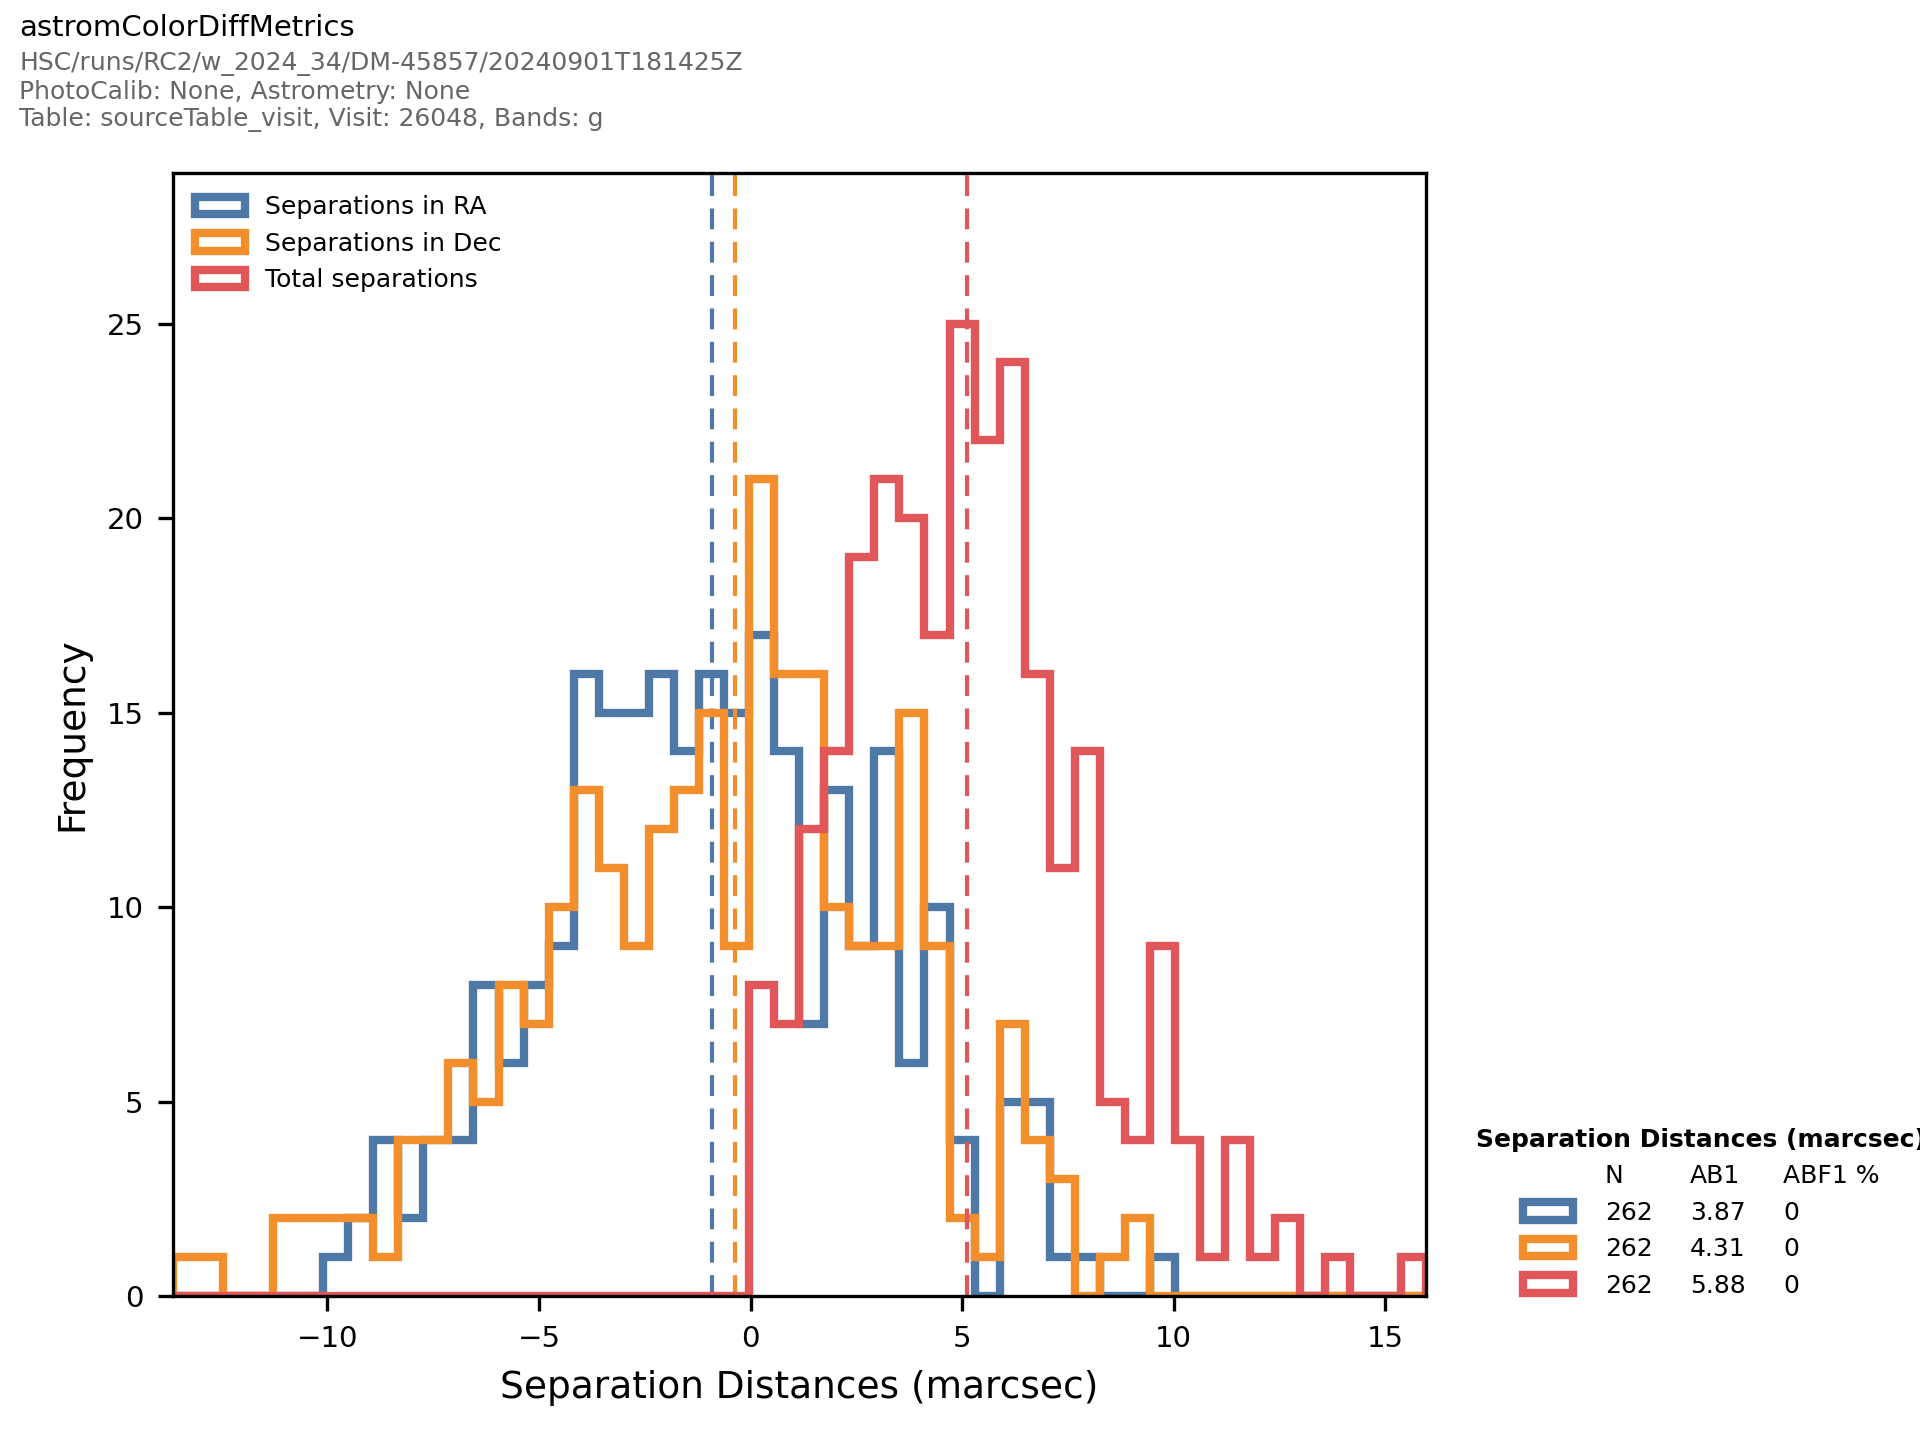

In [10]:
Image(plot_dict['sourceObjectTable_g_astromColorDiffMetrics_HistPlot'], width=600)

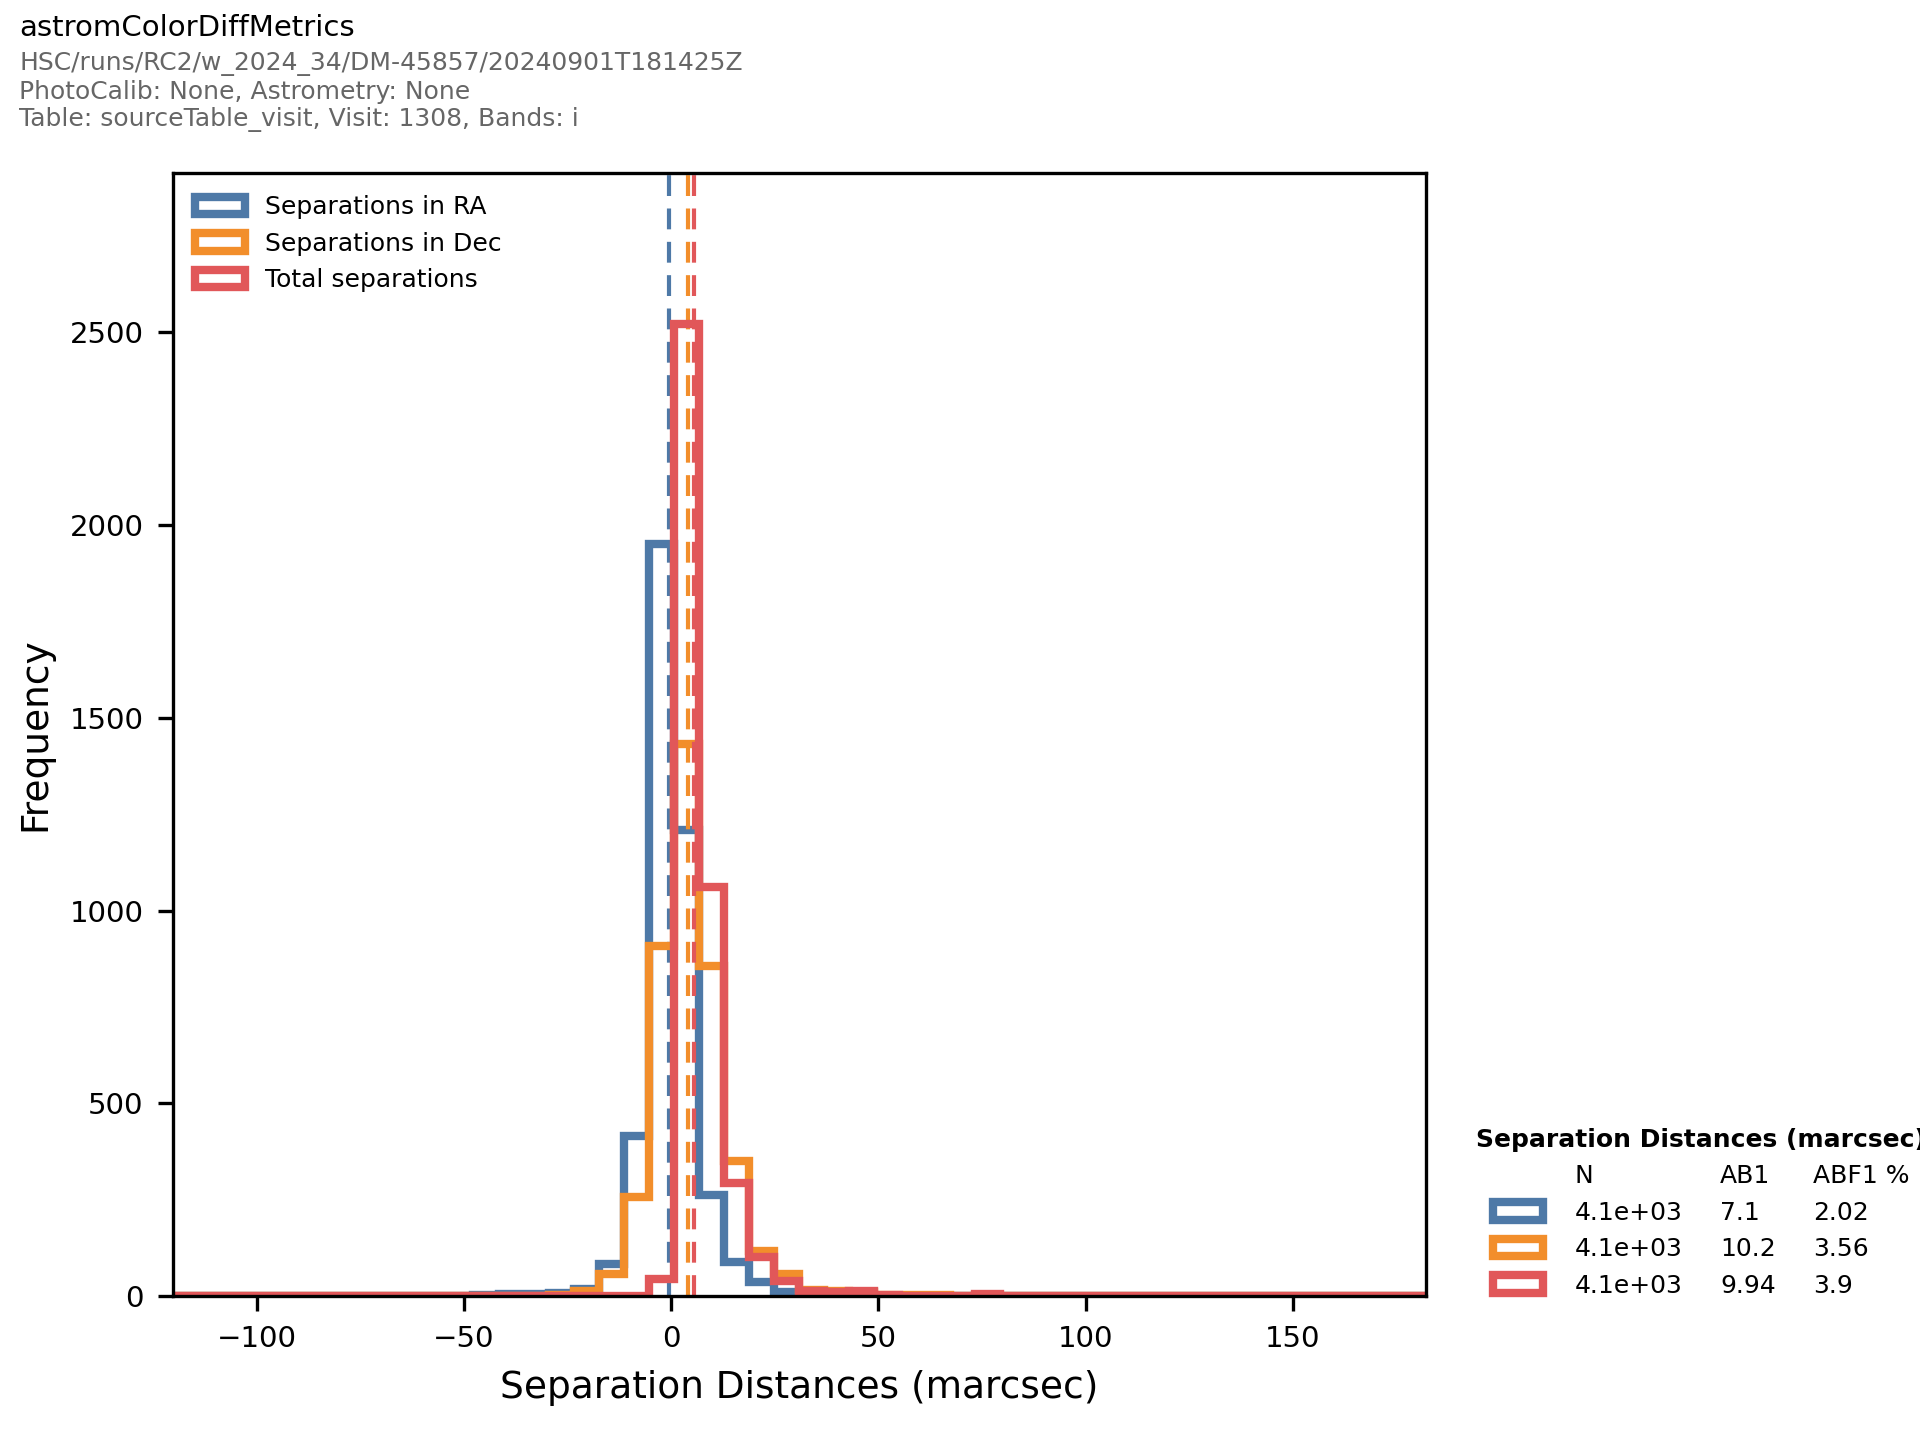

In [11]:
Image(plot_dict['sourceObjectTable_i_astromColorDiffMetrics_HistPlot'], width=600)

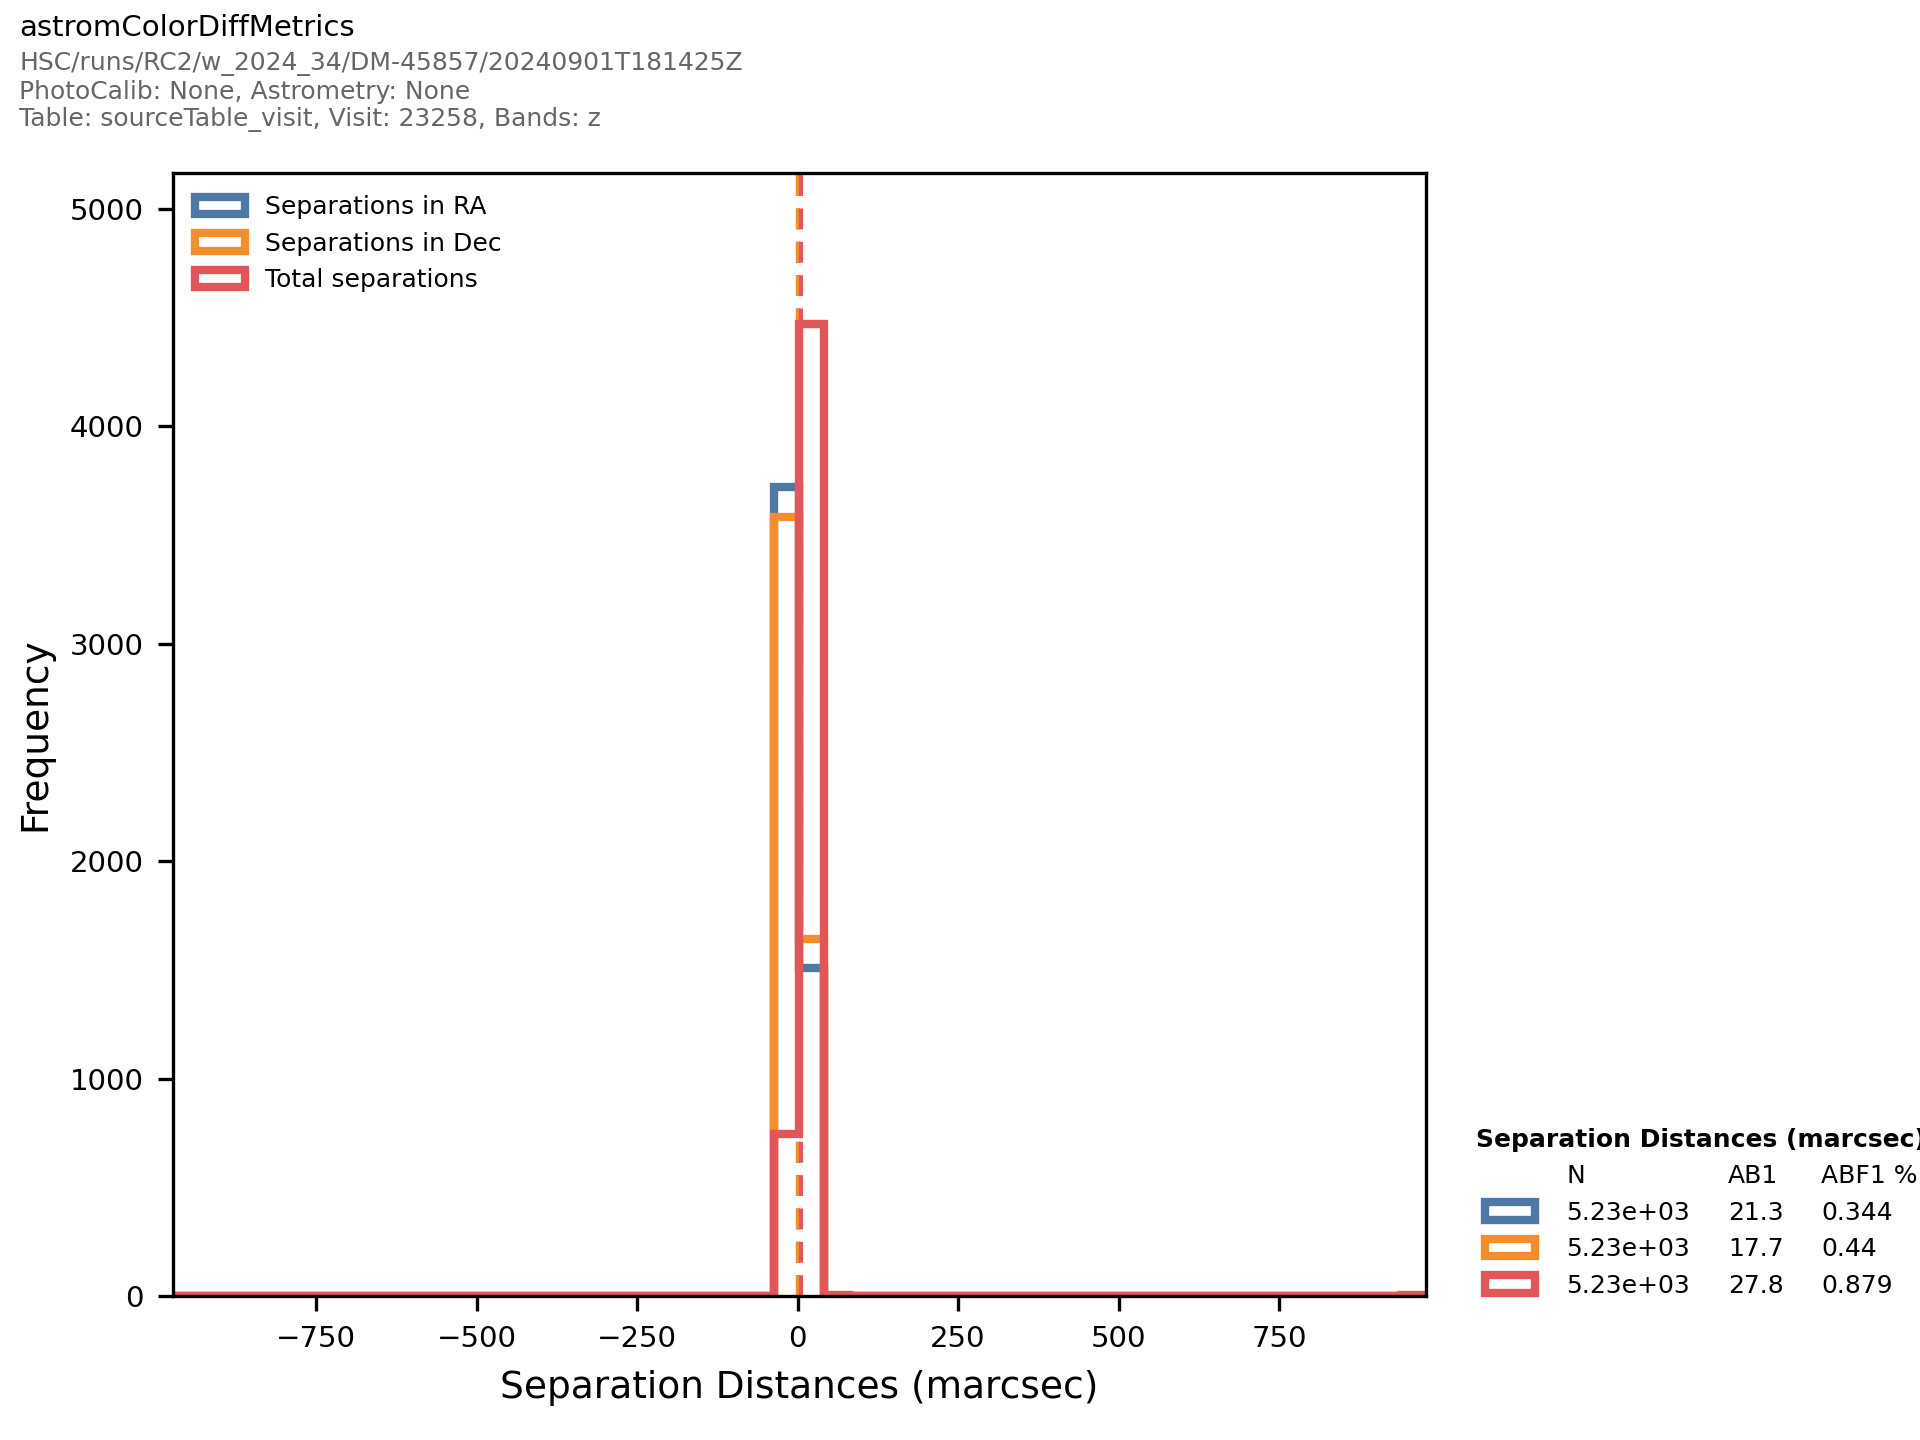

In [12]:
Image(plot_dict['sourceObjectTable_z_astromColorDiffMetrics_HistPlot'], width=600)

### Thresholds

To demonstrate that the AB2 threshold is applied, we inspect the relevant lines of `analysis_tools` [code that sets the AB2 threshold](https://github.com/lsst/analysis_tools/blob/6903dfedeb0232d1cc74fffcbea35eeab1598c08/python/lsst/analysis/tools/atools/refCatMatchPlots.py#L654-L660). We see the following, indicating that the threshold is being applied as required:
```
    AB2 = Field[float](
        doc=(
            "Separation in milliarcseconds used to calculate the ABF1 metric. ABF1 is the percentage of"
            " sources whose distance from the reference is greater than AB2 mas from the mean."
        ),
        default=20,
    )

```

## Results
We have demonstrated that there is software within the Rubin Science Pipelines to calculate `AB1`, the maximum astrometric separations measured relative to the r-band positions, and`ABF1` the percentage of separations relative to r-band that exceed the outlier threshold `AB2`. Additionally we have shown the metrics and plots that are produced by `analysis_tools` each time the DRP pipeline is executed. Thus the result of this test is a "**Pass**".